Importing Python Libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [82]:
data = pd.read_csv('data/apple_stock.csv')

In [83]:
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,12-12-1980,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1,15-12-1980,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
2,16-12-1980,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
3,17-12-1980,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
4,18-12-1980,0.091530,0.118862,0.119420,0.118862,0.118862,73449600


convert date column to a datetime type, setting it as index and focus on close price

In [85]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
data = data[['Close']]

In [86]:
print(data.index[-1])


2025-01-03 00:00:00


In [88]:
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10)

In [89]:
data.sort_index(inplace=True)

# LSTM (Long Short Term Memory)

Scaling between 0 and 1 

In [90]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

sequence of defined length

In [91]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data['Close'].values, seq_length)

split training(80%) and testing(20%)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Building LSTM model

In [93]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

Compiling with optimizer and loss function and fit into the training data

In [94]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 9.4245e-05
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 2.8118e-06
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 2.3018e-06
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 2.1069e-06
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 2.7094e-06
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.9561e-06
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 2.4441e-06
Epoch 8/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1.7747e-06
Epoch 9/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1.6109e-06
Epoch 10/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1.9929e-06
Epoch 11/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 1.4463e-06
Epoch 12/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 1.5282e-06
Epoch 13/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 1.3808e-06
Epoch 14/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 39

# Linear regression Model

Generating lagged feature for linear regression

In [95]:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)
data['Lag_3'] = data['Close'].shift(3)
data = data.dropna()

split into training and testing

In [96]:
X_lin = data[['Lag_1', 'Lag_2', 'Lag_3']]
y_lin = data['Close']
X_train_lin, X_test_lin = X_lin[:train_size], X_lin[train_size:]
y_train_lin, y_test_lin = y_lin[:train_size], y_lin[train_size:]

training model

In [97]:
lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Prediction using LSTM,
Inverse transform the scaled prediction

In [98]:
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


Prediction using Linear regression, Inverse transform the scaled prediction

In [99]:
lin_predictions = lin_model.predict(X_test_lin)
lin_predictions = scaler.inverse_transform(lin_predictions.reshape(-1, 1))

In [100]:
min_len = min(len(lstm_predictions), len(lin_predictions))
lstm_predictions = lstm_predictions[:min_len]
lin_predictions = lin_predictions[:min_len]

In [101]:
hybrid_predictions = (0.7 * lstm_predictions) + (0.3 * lin_predictions)

# Prediction using Hybrid model

LSTM for predicting for 10 days

In [102]:
lstm_future_predictions = []
last_sequence = X[-1].reshape(1, seq_length, 1)
for _ in range(10):
    lstm_pred = lstm_model.predict(last_sequence)[0, 0]
    lstm_future_predictions.append(lstm_pred)
    lstm_pred_reshaped = np.array([[lstm_pred]]).reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], lstm_pred_reshaped, axis=1)
lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Linear regression for predicting for 10 days

In [110]:
recent_data = data['Close'].values[-3:]
lin_future_predictions = []
feature_names = ['Lag_1', 'Lag_2', 'Lag_3']
for _ in range(10):
    input_df = pd.DataFrame([recent_data], columns=feature_names)
    lin_pred = lin_model.predict(input_df)[0]
    lin_future_predictions.append(lin_pred)
    recent_data = np.append(recent_data[1:], lin_pred)
lin_future_predictions = scaler.inverse_transform(np.array(lin_future_predictions).reshape(-1, 1))


Combination of both models for predicting for 10 days

In [111]:
hybrid_future_predictions = (0.7 * lstm_future_predictions) + (0.3 * lin_future_predictions)

final dataframe

In [112]:
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10)
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM Predictions': lstm_future_predictions.flatten(),
    'Linear Regression Predictions': lin_future_predictions.flatten(),
    'Hybrid Model Predictions': hybrid_future_predictions.flatten()
})
print(predictions_df)

        Date  LSTM Predictions  Linear Regression Predictions  \
0 2025-01-04        241.088837                     250.535110   
1 2025-01-05        237.447037                     244.146778   
2 2025-01-06        233.678848                     243.723678   
3 2025-01-07        229.917847                     250.636050   
4 2025-01-08        226.237045                     244.452677   
5 2025-01-09        222.679398                     243.592836   
6 2025-01-10        219.270569                     250.722612   
7 2025-01-11        216.024948                     244.767100   
8 2025-01-12        212.948547                     243.468265   
9 2025-01-13        210.041626                     250.794636   

   Hybrid Model Predictions  
0                243.922709  
1                239.456955  
2                236.692299  
3                236.133305  
4                231.701739  
5                228.953431  
6                228.706179  
7                224.647598  
8             

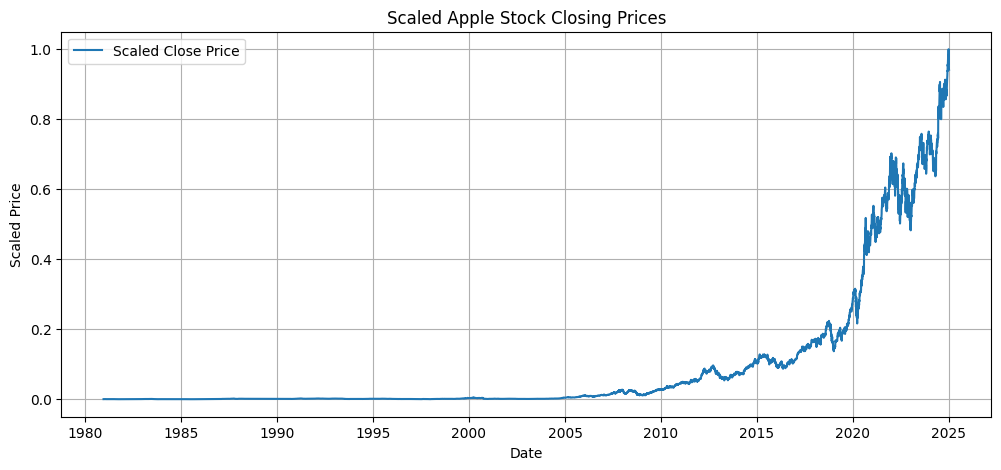

In [114]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Close'], label='Scaled Close Price')
plt.title('Scaled Apple Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid()
plt.show()

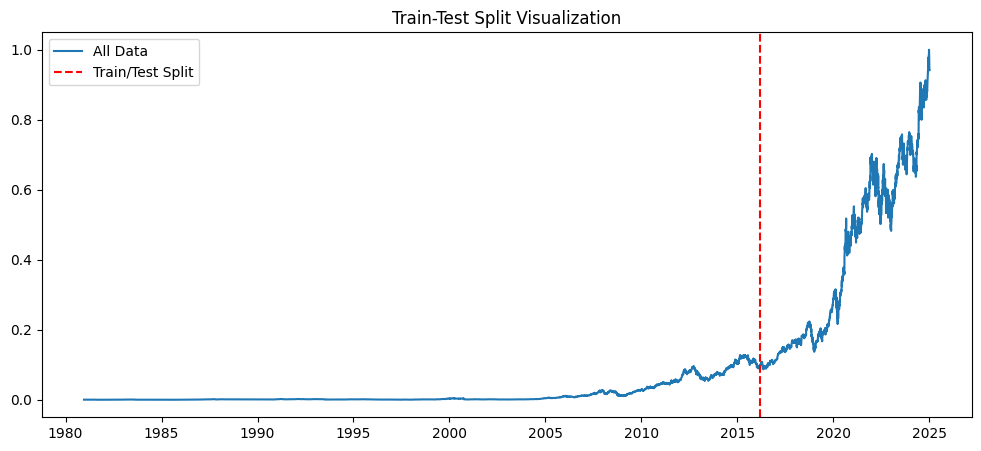

In [115]:
split_index = int(len(data) * 0.8)
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Close'], label='All Data')
plt.axvline(data.index[split_index], color='r', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()

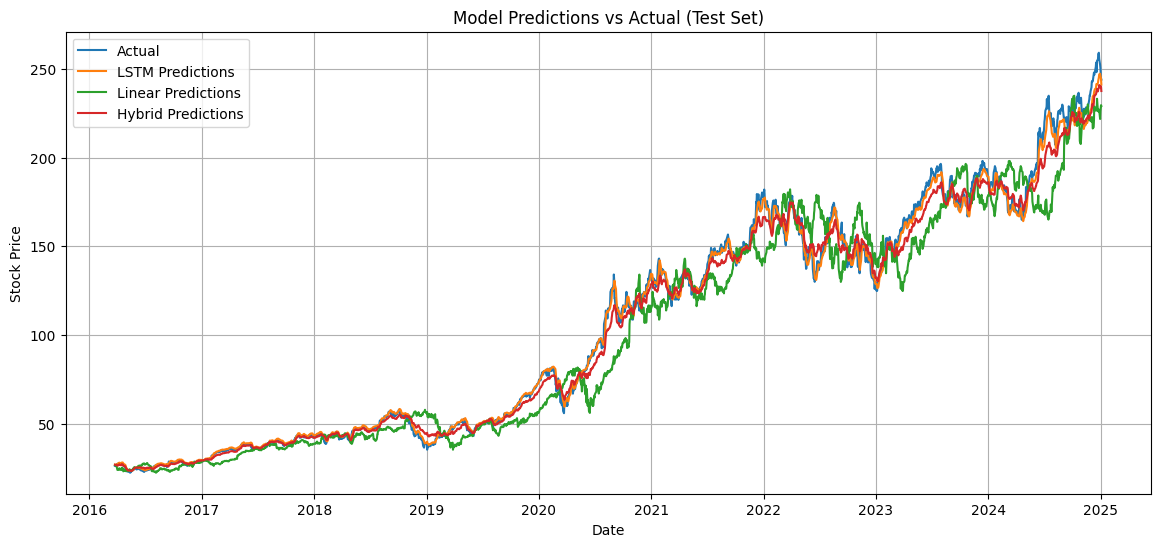

In [116]:
test_dates = data.index[-min_len:]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, scaler.inverse_transform(y_test[-min_len:].reshape(-1, 1)), label='Actual')
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions')
plt.plot(test_dates, lin_predictions, label='Linear Predictions')
plt.plot(test_dates, hybrid_predictions, label='Hybrid Predictions')
plt.title('Model Predictions vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

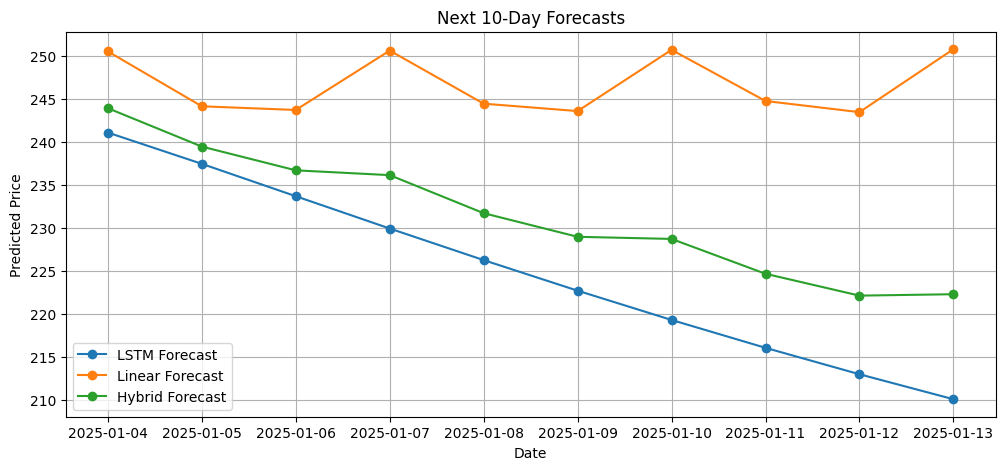

In [117]:
plt.figure(figsize=(12, 5))
plt.plot(predictions_df['Date'], predictions_df['LSTM Predictions'], marker='o', label='LSTM Forecast')
plt.plot(predictions_df['Date'], predictions_df['Linear Regression Predictions'], marker='o', label='Linear Forecast')
plt.plot(predictions_df['Date'], predictions_df['Hybrid Model Predictions'], marker='o', label='Hybrid Forecast')
plt.title('Next 10-Day Forecasts')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()


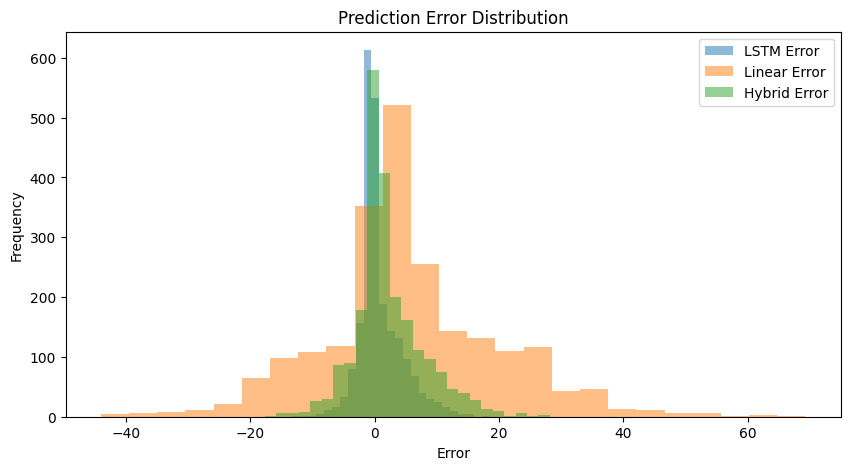

In [119]:
actual = scaler.inverse_transform(y_test[-min_len:].reshape(-1, 1))
errors = {
    'LSTM': actual - lstm_predictions,
    'Linear': actual - lin_predictions,
    'Hybrid': actual - hybrid_predictions
}

plt.figure(figsize=(10, 5))
for name, err in errors.items():
    plt.hist(err, bins=25, alpha=0.5, label=f'{name} Error')

plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
